<a href="https://colab.research.google.com/github/alenthankz/Human_Age_recognition/blob/main/Human_age_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Stage 1: Import dependencies and setting up environment

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import zipfile
import os
import matplotlib.pyplot as plt 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tqdm import tqdm_notebook

### Downloading dataset

In [ ]:
!gdown 'https://drive.google.com/uc?id=10RpTiLuvVvg-3OkGnlkXmDDJggWXNDnH'
#only if opened in colab

Downloading...
From: https://drive.google.com/uc?id=10RpTiLuvVvg-3OkGnlkXmDDJggWXNDnH
To: /content/human-age-recognition.zip
381MB [00:03, 108MB/s]


## Stage 2: Dataset preprocessing

### Unzipping the dataset 

In [ ]:
dataset_path = "./human-age-recognition.zip"
zip_object = zipfile.ZipFile(file=dataset_path, mode="r")
zip_object.extractall("./")
zip_object.close()

In [ ]:
"""
dataset_path = "./trainZip.zip"
zip_object = zipfile.ZipFile(file=dataset_path, mode="r")
zip_object.extractall("./")
zip_object.close()
"""

In [ ]:
"""
dataset_path = "./testZip.zip"
zip_object = zipfile.ZipFile(file=dataset_path, mode="r")
zip_object.extractall("./")
zip_object.close()
"""

### Seting up dataset paths

In [ ]:
train_dir = "./train"
test_dir = "./test"

In [ ]:
#os.mkdir("./test_")
#os.mkdir("./test_/images")
#import shutil 
#shutil.copy(test_dir,"./test_/images")
#test_dir = "./test_"



In [ ]:
IMG_SHAPE = (224, 224, 3)
HEIGHT =224
WEIGHT=224
BATCH_SIZE=128
NO_OF_CLASSES = len ( os.listdir(train_dir) )
CLASSES_DICT = {
    0 : 'Age_1 to Age_10',
    1 : 'Age_11 to Age_20',
    2 : 'Age_21 to Age_30',
    3 : 'Age_31 to Age_40',
    4 : 'Age_41 to Age_50',
    5 : 'Age_51 to Age_60',
    6 : 'Age_61 to Age_70',
    7 : 'Age_71 to Age_80'
}

### Visualising

Text(0, 0.5, 'Number of Images present')

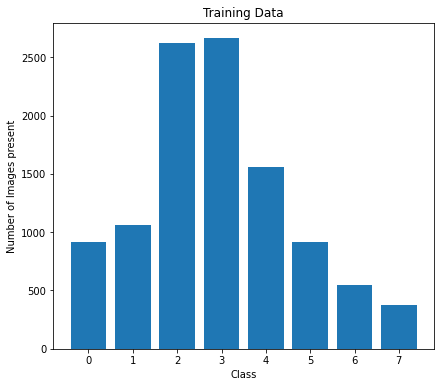

In [ ]:
path_train_ls = [ str(i) for i in range(NO_OF_CLASSES)]
number_train_ls = [  len( os.listdir( os.path.join(train_dir,str(folder)) ) )  for folder in range(NO_OF_CLASSES) ]


plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.bar(path_train_ls,number_train_ls)
plt.title("Training Data")
plt.xlabel("Class")
plt.ylabel("Number of Images present")

### Calculating class weight 

In [ ]:
total_train_ls = sum(number_train_ls)
CLASS_WEIGHTS={}

In [ ]:
for i in range(NO_OF_CLASSES):
    CLASS_WEIGHTS[i]= 1/number_train_ls[i] * total_train_ls/2

CLASS_WEIGHTS

{0: 5.797826086956522,
 1: 5.017873941674506,
 2: 2.0351011064479207,
 3: 2.0022522522522523,
 4: 3.428020565552699,
 5: 5.804134929270947,
 6: 9.698181818181817,
 7: 14.224}

## Stage 3: Building the model

### Loading the pre-trained model (ResNet50)

In [ ]:

base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")


In [ ]:
base_model.trainable = True

In [ ]:
print("Number of layersin the base model: {}".format(len(base_model.layers)))

Number of layersin the base model: 175


### Fine tuning

In [ ]:
fine_tune_at = 120
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
base_model.output

<KerasTensor: shape=(None, 7, 7, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

### Defining the custom head for our network

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
global_average_layer

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'global_average_pooling2d')>

In [ ]:
prediction_layer = tf.keras.layers.Dense(units=NO_OF_CLASSES, activation='softmax')(global_average_layer)

### Defining the model

In [ ]:
model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)

### Compiling the model

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer="Adam", metrics=["categorical_accuracy"])

## Stage 4: Creating Data Generators

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255 , validation_split=0.2)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(HEIGHT, WEIGHT), batch_size=BATCH_SIZE, class_mode="categorical", subset = "training")
validation_generator =train_datagen.flow_from_directory(train_dir,target_size=(HEIGHT, WEIGHT), batch_size=BATCH_SIZE, class_mode="categorical", subset = "validation")

Found 8537 images belonging to 8 classes.
Found 2131 images belonging to 8 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255,)
test_generator = test_datagen.flow_from_directory(test_dir,target_size=(HEIGHT, WEIGHT), batch_size=BATCH_SIZE)

Found 2664 images belonging to 1 classes.


### Stage 5: Training the model

In [ ]:
 history = model.fit(train_generator, epochs=5,validation_data = validation_generator, class_weight=CLASS_WEIGHTS)

In [ ]:
model.save('./last_trained_model')

## Stage 6: Loading the best trained model

In [ ]:
mymodel = tf.keras.models.load_model('./last_trained_model')

## Stage 7: Predicting 

In [ ]:
pred = mymodel.predict(test_generator)
predictions = [np.argmax(i) for i in pred]

In [ ]:
#ls = os.listdir(  test_dir + "/images"   )
#if running locally
ls = os.listdir(  test_dir + "/test_"   )
#if in colabs

ls.sort()

test_df = pd.DataFrame(ls, columns = ["Image Name"])
test_df["Labels"] = predictions
test_df.to_csv('./submission.csv',index=False)
test_df.head(20)

,Image Name,Labels
0,000010.jpg,2
1,0000100.jpg,2
2,00001000.jpg,2
3,000010000.jpg,2
4,000010005.jpg,2
